In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [3]:
import sklearn
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [5]:
df = pd.read_csv(r'C:\Users\admin\Downloads\Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.shape

(6362620, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
df.isnull().sum().any()

False

In [9]:
df.duplicated().sum().any()

False

In [10]:
df.type.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

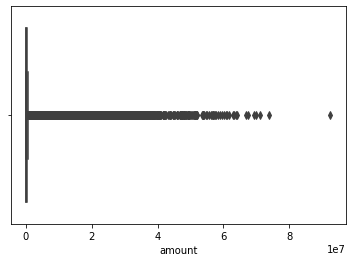

In [11]:
sns.boxplot(df.amount)
plt.show()

In [12]:
max(df.amount)

92445516.64

In [13]:
df.amount.describe()

count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

From the above table we can see that the 50th Percentile, and the maximum amount have a huge difference. The box plot also confirms it to be an outlier. Hence, we can remove the outlier.  

In [14]:
df[df.amount>85000000.00].shape

(1, 11)

In [15]:
df = df[df.amount<85000000.00]

In [16]:
df.type.value_counts(normalize = True)

CASH_OUT    0.351663
PAYMENT     0.338146
CASH_IN     0.219923
TRANSFER    0.083756
DEBIT       0.006512
Name: type, dtype: float64

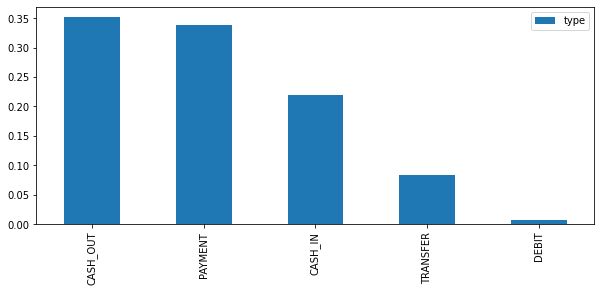

In [17]:
plt.figure(figsize=[10,4])
df.type.value_counts(normalize=True).plot.bar()
plt.legend()
plt.show()

In [18]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [19]:
df.isFraud.value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [20]:
df.isFlaggedFraud.value_counts(normalize=True)

0    0.999997
1    0.000003
Name: isFlaggedFraud, dtype: float64

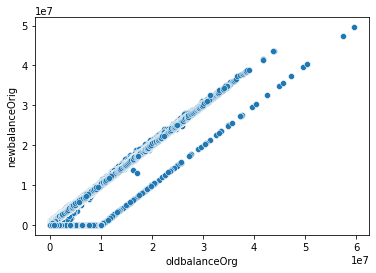

In [21]:
sns.scatterplot(data=df, x = 'oldbalanceOrg', y = 'newbalanceOrig')
plt.show()

In [22]:
res = df[['oldbalanceOrg', 'oldbalanceDest', 'newbalanceOrig', 'newbalanceDest']].corr()
res

,oldbalanceOrg,oldbalanceDest,newbalanceOrig,newbalanceDest
oldbalanceOrg,1.000000,0.066242,0.998803,0.042032
oldbalanceDest,0.066242,1.000000,0.067812,0.976617
newbalanceOrig,0.998803,0.067812,1.000000,0.041841
newbalanceDest,0.042032,0.976617,0.041841,1.000000


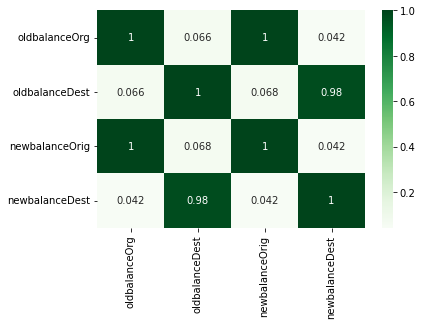

In [23]:
sns.heatmap(data=res, annot = True, cmap = 'Greens')
plt.show()

Checking error in balances for all transactions irrespective of mode.

In [24]:
df['originalbalanceerror'] = (df.newbalanceOrig + df.amount) - df.oldbalanceOrg

In [25]:
df['balancedesterror'] = (df.newbalanceDest + df.amount) - df.oldbalanceDest

In [26]:
df.type.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532908
DEBIT         41432
Name: type, dtype: int64

In [27]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,originalbalanceerror,balancedesterror
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0.0,9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0.0,1864.28
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0.0,181.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0.0,-21001.00
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0.0,11668.14


In [28]:
tfraud = df.isFraud.value_counts()
tfraud

0    6354406
1       8213
Name: isFraud, dtype: int64

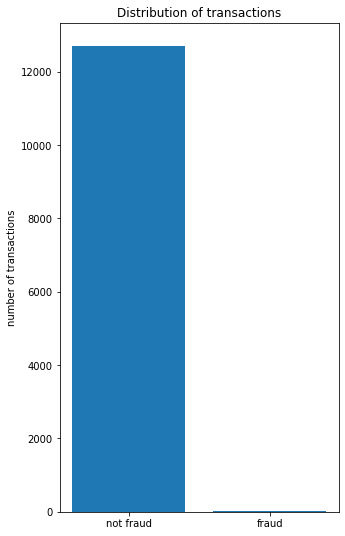

In [29]:
fraudplot = plt.figure(figsize=(5,9))
plt.bar(['not fraud','fraud'], tfraud.values/500)
plt.title('Distribution of transactions')
plt.ylabel('number of transactions')
plt.show()

In [30]:
fraud_type = df[df.isFraud == 1]['type'].value_counts()
fraud_type

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

In [31]:
fraud_t = []
for ty in ['CASH_OUT', 'PAYMENT', 'CASH_IN', 'TRANSFER', 'DEBIT']:
    try:
        fraud_t.append(fraud_type[ty])
    except:
        fraud_t.append(0)

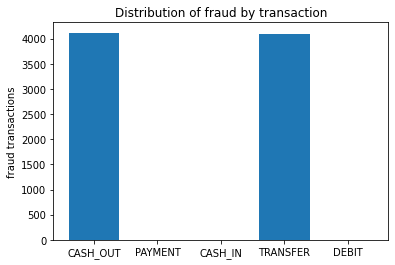

In [32]:
tf_plot = plt.figure()
plt.bar(['CASH_OUT', 'PAYMENT', 'CASH_IN', 'TRANSFER', 'DEBIT'],fraud_t)
plt.title('Distribution of fraud by transaction')
plt.ylabel('fraud transactions')
plt.show()

The fraud examples are equally distributed between the types cash out, and transfer.

Data Modelling

In [33]:
data = df[(df['type'] == 'CASH_OUT') | (df['type'] == 'TRANSFER')]
data = data.drop(['nameOrig','nameDest'],axis = 1)
data['type'].replace('TRANSFER', 0, inplace = True)
data['type'].replace('CASH_OUT', 1, inplace = True)

In [34]:
y = data.isFraud
x = data.drop(['isFraud'],axis = 1)

Resampling the data

In [35]:
x_resample, y_resample = SMOTE().fit_resample(x, y.values.ravel())

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x_resample, y_resample, test_size = 0.1, random_state = 0)

Scaling the data

In [37]:
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

Training the model

In [38]:
model = LogisticRegression()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

Metrics

In [39]:
print('accuracy : {}'.format(model.score(x_test,y_test)))
print('average precision score : {}'.format(average_precision_score(y_test,y_pred)))
print('confusion matrix :\n  {}'.format(confusion_matrix(y_test,y_pred)))
print('classification report :')
print(classification_report(y_test,y_pred))

accuracy : 0.9481445010218322
average precision score : 0.925022164664033
confusion matrix :
  [[261780  14282]
 [ 14365 262012]]
classification report :
              precision    recall  f1-score   support

           0       0.95      0.95      0.95    276062
           1       0.95      0.95      0.95    276377

    accuracy                           0.95    552439
   macro avg       0.95      0.95      0.95    552439
weighted avg       0.95      0.95      0.95    552439



Using xgboost

In [40]:
model = XGBClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

[10:42:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Metrics

In [41]:
print('accuracy : {}'.format(model.score(x_test,y_test)))
print('average precision score : {}'.format(average_precision_score(y_test,y_pred)))
print('confusion matrix :\n  {}'.format(confusion_matrix(y_test,y_pred)))
print('classification report :')
print(classification_report(y_test,y_pred))

accuracy : 0.9996180573782807
average precision score : 0.9994068838050494
confusion matrix :
  [[275945    117]
 [    94 276283]]
classification report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    276062
           1       1.00      1.00      1.00    276377

    accuracy                           1.00    552439
   macro avg       1.00      1.00      1.00    552439
weighted avg       1.00      1.00      1.00    552439

